Classical Brownian Motion: Mean = 99.99815662798417, Std Dev = 0.0987556568176121
Arithmetic Return System: Mean = 100.10988005872944, Std Dev = 9.930546809674302
Log Return (GBM): Mean = 100.44097996457594, Std Dev = 10.023662034365971


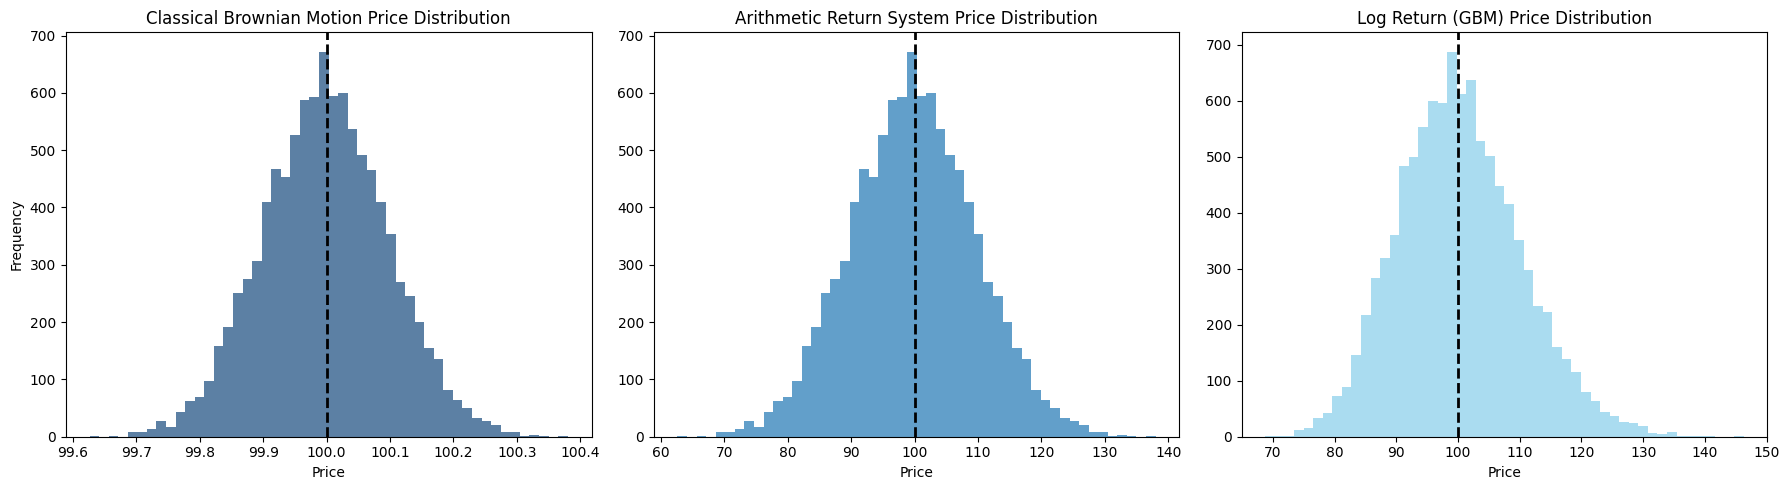

In [7]:
#Problem 1
import numpy as np
import matplotlib.pyplot as plt

# Given values for the simulation
P_t_minus_1 = 100
sigma = 0.1
num_simulations = 10000

np.random.seed(0)
CBM_returns = np.random.normal(0, sigma, num_simulations)
ARS_returns = np.random.normal(0, sigma, num_simulations)
GRM_returns = np.random.normal(0, sigma, num_simulations)

CBM_prices = P_t_minus_1 + CBM_returns
ARS_prices = P_t_minus_1 * (1 + ARS_returns)
GRM_prices = P_t_minus_1 * np.exp(GRM_returns)

CBM_mean, CBM_std = np.mean(CBM_prices), np.std(CBM_prices)
ARS_mean, ARS_std = np.mean(ARS_prices), np.std(ARS_prices)
GRM_mean, GRM_std = np.mean(GRM_prices), np.std(GRM_prices)

print(f"Classical Brownian Motion: Mean = {CBM_mean}, Std Dev = {CBM_std}")
print(f"Arithmetic Return System: Mean = {ARS_mean}, Std Dev = {ARS_std}")
print(f"Log Return (GBM): Mean = {GRM_mean}, Std Dev = {GRM_std}")

# Simulate random returns
np.random.seed(0)
returns = np.random.normal(0, sigma, num_simulations)
CBM_prices = P_t_minus_1 + returns
ARS_prices = P_t_minus_1 * (1 + returns)
GRM_prices = P_t_minus_1 * np.exp(returns)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.hist(CBM_prices, bins=50, alpha=0.7, color='#174a7e')
plt.axvline(P_t_minus_1, color='black', linestyle='dashed', linewidth=2)
plt.title('Classical Brownian Motion Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(ARS_prices, bins=50, alpha=0.7, color='#1f77b4')
plt.axvline(P_t_minus_1, color='black', linestyle='dashed', linewidth=2)
plt.title('Arithmetic Return System Price Distribution')
plt.xlabel('Price')

plt.subplot(1, 3, 3)
plt.hist(GRM_prices, bins=50, alpha=0.7, color='#87CEEB')
plt.axvline(P_t_minus_1, color='black', linestyle='dashed', linewidth=2)
plt.title('Log Return (GBM) Price Distribution')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

In [5]:
#Problem 2
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import t
import statsmodels.api as sm

# Function to calculate returns
def return_calculate(prices, method="DISCRETE", date_column="Date"):
    if date_column not in prices.columns:
        raise ValueError(f"dateColumn: {date_column} not in DataFrame: {prices.columns.tolist()}")
    
    # Extract the columns that are not the date column
    vars = [col for col in prices.columns if col != date_column]
    p = prices[vars].values
    n, m = p.shape

    # Calculate the returns
    if method.upper() == "DISCRETE":
        # Discrete returns: (Price_t+1 / Price_t) - 1
        p2 = (p[1:] / p[:-1]) - 1
    elif method.upper() == "LOG":
        # Log returns: log(Price_t+1 / Price_t)
        p2 = np.log(p[1:] / p[:-1])
    else:
        raise ValueError(f"method: {method} must be in (\"LOG\", \"DISCRETE\")")

    # Create the output DataFrame
    dates = prices[date_column].iloc[1:].reset_index(drop=True)
    out = pd.DataFrame(data=p2, columns=vars)
    out.insert(0, date_column, dates)
    
    return out

# Load the CSV file into a DataFrame
file_path = '/Users/queenieliu/FinTech545_Spring2024/Week04/DailyPrices.csv'
prices = pd.read_csv(file_path)

# Calculate the arithmetic returns for all prices
returns = return_calculate(prices, method="DISCRETE")

# Display the first few rows of the returns
returns.head()
returns.to_csv('/Users/queenieliu/FinTech545_Spring2024/Week04/Project/arithmetic_returns.csv', index=False)

# Get the mean of META and center it
meta_returns = returns['META']
meta_returns_centered = meta_returns - meta_returns.mean()

confidence_level = 0.95
z_score = norm.ppf(1 - confidence_level)

# Calculate the VaR using a Normal Distribution
std_dev1 = meta_returns_centered.std()
VaR = -z_score * std_dev1
print(f"Use normal distribution, the VaR at {confidence_level * 100}% confidence level is: {VaR}")


# Calculate the VaR using a normal distribution with an Exponentially Weighted variance
lambda_factor = 0.94
ewma_variance = meta_returns_centered.ewm(alpha=(1 - lambda_factor)).var()
std_dev2 = ewma_variance.apply(np.sqrt).iloc[-1]
VaR_ewma = -z_score * std_dev2
print(f"Use normal distribution with EWMA model, the VaR at {confidence_level * 100}% confidence level is: {VaR_ewma}")

# Calculate the VaR using MLE fitted T-distribution
params = t.fit(meta_returns_centered.dropna()) 
degrees_of_freedom, loc, scale = params
VaR_t_dist = -t.ppf(1 - confidence_level, degrees_of_freedom, loc=loc, scale=scale)
print(f"Use MLE fitted T-distribution, the VaR at {confidence_level * 100}% confidence level is: {VaR_t_dist}")

# Calculate the VaR using a fitted AR(1) model
ar_model = sm.tsa.ARIMA(meta_returns_centered.dropna(), order=(1, 0, 0))
ar_result = ar_model.fit()
phi_0 = ar_result.params[0]
phi_1 = ar_result.params[1]
sigma = ar_result.resid.std()
next_return_forecast = ar_result.predict(start=len(meta_returns_centered), end=len(meta_returns_centered))
VaR_ar1 = -z_score * sigma
print(f"Use fitted AR(1) model, the VaR at {confidence_level * 100}% confidence level is: {VaR_ar1}")

# Calculate the VaR using a Historic Simulation
sorted_returns = meta_returns_centered.sort_values()
var_index = int((1 - confidence_level) * len(sorted_returns))
VaR_historic = -sorted_returns.iloc[var_index]
print(f"Use historic simulation, the VaR at {confidence_level * 100}% confidence level is: {VaR_historic}")

Use normal distribution, the VaR at 95.0% confidence level is: 0.054286932422546966
Use normal distribution with EWMA model, the VaR at 95.0% confidence level is: 0.030137068179582522
Use MLE fitted T-distribution, the VaR at 95.0% confidence level is: 0.04313471495037608
Use fitted AR(1) model, the VaR at 95.0% confidence level is: 0.05422924049319295
Use historic simulation, the VaR at 95.0% confidence level is: 0.0395076854830965


/var/folders/j2/46x10ypj40jfxgs8f1fmbdhr0000gn/T/ipykernel_24523/4032751120.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi_0 = ar_result.params[0]
/var/folders/j2/46x10ypj40jfxgs8f1fmbdhr0000gn/T/ipykernel_24523/4032751120.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi_1 = ar_result.params[1]


In [18]:
#Problem 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize 
from statsmodels.tsa.arima.model import ARIMA

portfolio = pd.read_csv('/Users/queenieliu/FinTech545_Spring2024/Week04/Project/portfolio.csv')
prices = pd.read_csv('/Users/queenieliu/FinTech545_Spring2024/Week04/DailyPrices.csv')

def calculate_returns(prices, method="DISCRETE", dateColumn="Date", mean_adjust=False):
    vars = prices.columns
    vars = [var for var in vars if var != dateColumn]
    nVars = len(vars)
    p = np.array(prices[vars])
    n = p.shape[0]
    p2 = np.empty((n-1, nVars))
    for i in range(n-1):
        for j in range(nVars):
            p2[i, j] = p[i+1, j] / p[i, j]
    if method.upper() not in ("LOG", "DISCRETE"):
        raise ValueError("method must be 'LOG' or 'DISCRETE'")
    if mean_adjust:
        p2 -= p2.mean(axis=0)
    dates = prices[dateColumn][1:n].values
    out = pd.DataFrame(p2, columns=vars)
    out.insert(0, dateColumn, dates)
    return out


def exp_weighted_cov(input, lambda_=0.94):
    ror = input.values
    ror_mean = np.mean(ror, axis=0)
    dev = ror - ror_mean
    times = dev.shape[0]
    weights = np.zeros(times)
    for i in range(times):
        weights[times - i - 1]  = (1 - lambda_) * lambda_**i
    weights_mat = np.diag(weights/sum(weights))

    cov = np.transpose(dev) @ weights_mat @ dev
    return cov

def get_portfolio(portfolio, prices, code):
    assets = portfolio[portfolio["Portfolio"] == code]
    stocks = list(assets["Stock"])
    assets_prices = prices[["Date"] + stocks].copy()
    Total_Value = prices[stocks].tail(1).values.dot(assets["Holding"].values)[0]
    holdings = assets["Holding"].values
    asset_values = holdings.reshape(-1, 1) * prices[stocks].tail(1).T.values
    delta = asset_values / Total_Value
    return Total_Value, assets_prices, holdings, delta

def get_all_portfolio(portfolio, prices):
    assets = portfolio.drop('Portfolio',axis=1)
    assets = assets.groupby(["Stock"], as_index=False)["Holding"].sum()
    stocks = list(assets["Stock"])
    assets_prices = prices[["Date"] + stocks].copy()
    Total_Value = prices[stocks].tail(1).values.dot(assets["Holding"].values)[0]
    holdings = assets["Holding"].values
    asset_values = holdings.reshape(-1, 1) * prices[stocks].tail(1).T.values
    delta = asset_values / Total_Value
    return Total_Value, assets_prices, holdings, delta
    
Total_Value_A, assets_prices_A, holdings_A, delta_A = get_portfolio(portfolio, prices, "A")
Total_Value_B, assets_prices_B, holdings_B, delta_B = get_portfolio(portfolio, prices, "B")
Total_Value_C, assets_prices_C, holdings_C, delta_C = get_portfolio(portfolio, prices, "C")
Total_Value_All, assets_prices_All, holdings_All, delta_All = get_all_portfolio(portfolio, prices)


def cal_delta_VaR(Total_Value, assets_prices, delta, alpha=0.05, lambda_=0.94):
    returns = calculate_returns(assets_prices, mean_adjust=True).drop('Date', axis=1)
    assets_cov = exp_weighted_cov(returns, lambda_)
    delta_norm_VaR = -Total_Value * stats.norm.ppf(alpha) * np.sqrt(delta.T @ assets_cov @ delta)
    return delta_norm_VaR.item()

delta_var_A = cal_delta_VaR(Total_Value_A, assets_prices_A, delta_A)
delta_var_B = cal_delta_VaR(Total_Value_B, assets_prices_B, delta_B)
delta_var_C = cal_delta_VaR(Total_Value_C, assets_prices_C, delta_C)
delta_var_All = cal_delta_VaR(Total_Value_All, assets_prices_All, delta_All)
print("The VaR of EWMA model for portfolio A is ${}".format(delta_var_A))
print("The VaR of EWMA model for portfolio B is ${}".format(delta_var_B))
print("The VaR of EWMA model for portfolio C is ${}".format(delta_var_C))
print("The VaR of EWMA model for all portfolios is ${}".format(delta_var_All))

# Use the historical value for VaR
def cal_hist_VaR(assets_prices, holdings, alpha=0.05):
    returns = calculate_returns(assets_prices, mean_adjust=True).drop('Date', axis=1)
    assets_prices = assets_prices.drop('Date',axis=1)
    simu_returns = returns.sample(10000, replace=True)
    simu_prices = np.dot(simu_returns* assets_prices.tail(1).values.reshape(assets_prices.shape[1],),holdings)

    hist_VaR = -np.percentile(simu_prices, alpha*100)

    return hist_VaR

hist_var_A = cal_hist_VaR(assets_prices_A, holdings_A)
hist_var_B = cal_hist_VaR(assets_prices_B, holdings_B)
hist_var_C = cal_hist_VaR(assets_prices_C, holdings_C)
hist_var_All = cal_hist_VaR(assets_prices_All, holdings_All)
print("The VaR with historical data of portfolio A is ${}".format(hist_var_A))
print("The VaR with historical data of portfolio B is ${}".format(hist_var_B))
print("The VaR with historical data of portfolio C is ${}".format(hist_var_C))
print("The VaR with historical data for all portfolios is ${}".format(hist_var_All))

# Data for plotting
portfolios = ['Portfolio A', 'Portfolio B', 'Portfolio C', 'All Portfolios']
ewma_vars = [delta_var_A, delta_var_B, delta_var_C, delta_var_All]
hist_vars = [hist_var_A, hist_var_B, hist_var_C, hist_var_All]
x = range(len(portfolios))
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35 
r1 = np.arange(len(ewma_vars))
r2 = [x + bar_width for x in r1]

# Make the plot
ax.bar(r1, ewma_vars, color='#174a7e', width=bar_width, edgecolor='grey', label='EWMA VaR')
ax.bar(r2, hist_vars, color='#1f77b4', width=bar_width, edgecolor='grey', label='Historical VaR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Portfolios')
ax.set_ylabel('Value at Risk (VaR)')
ax.set_title('Comparison of VaR by EWMA Model and Historical Simulation')
ax.set_xticks([r + bar_width/2 for r in range(len(ewma_vars))])
ax.set_xticklabels(portfolios)
ax.legend()

# Create labels on top of the bars
def add_labels(values, offset):
    for i in range(len(values)):
        plt.text(x = r1[i] + offset, y = values[i], s = round(values[i], 2), ha = 'center', va = 'bottom')

# Call functions to add labels
add_labels(ewma_vars, bar_width/2)
add_labels(hist_vars, bar_width)

# Save the figure
plt.tight_layout()
plt.savefig('/Users/queenieliu/FinTech545_Spring2024/Week04/Project')

plt.show()

The VaR of EWMA model for portfolio A is $15426.968017012965
The VaR of EWMA model for portfolio B is $8082.5724022843915
The VaR of EWMA model for portfolio C is $18163.291619061267
The VaR of EWMA model for all portfolios is $38941.37572890159
The VaR with historical data of portfolio A is $18320.25898017049
The VaR with historical data of portfolio B is $11340.168567341952
The VaR with historical data of portfolio C is $23807.764522925103
The VaR with historical data for all portfolios is $51701.82870016339
